In [40]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np


In [6]:
import tensorflow as tf
print(tf.version)

<module 'tensorflow_core._api.v2.version' from '/home/gautham/anaconda3/lib/python3.7/site-packages/tensorflow_core/_api/v2/version/__init__.py'>


In [2]:
model = ResNet50(weights='imagenet')

In [16]:
img_path = 'elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [17]:
import matplotlib.pyplot as plt

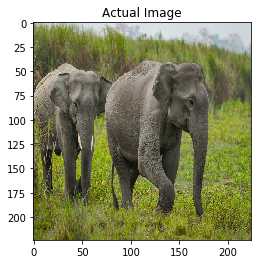

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


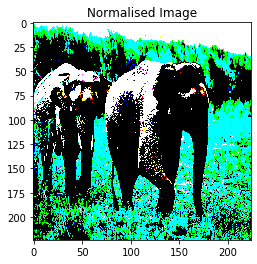

In [15]:
plt.title("Actual Image")
plt.imshow(img)
plt.show()
plt.title("Normalised Image")
plt.imshow(x[0])
plt.show()

In [18]:
preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])
# Predicted: [(u'n02504013', u'Indian_elephant', 0.82658225), (u'n01871265', u'tusker', 0.1122357), (u'n02504458', u'African_elephant', 0.061040461)]


Predicted: [('n01871265', 'tusker', 0.5334064), ('n02504458', 'African_elephant', 0.28311172), ('n02504013', 'Indian_elephant', 0.1827518)]


In [19]:
# Transfer Learning

In [2]:
import os
folders = os.listdir("images")
print(folders)

['dogs', 'humans', 'horses', 'cats']


In [3]:
image_data = []

labels = []

label_dict = {
    "cats":0,
    "dogs":1,
    "horses":2,
    "humans":3
}

In [17]:
for ix in folders:
    print(ix)

dogs
humans
horses
cats


In [12]:
from keras.preprocessing import image
for ix in folders:
    path = os.path.join("images",ix)
    for im in os.listdir(path):
        img = image.load_img(os.path.join(path,im),target_size=((224,224)))
        img_array = image.img_to_array(img)
        image_data.append(img_array)
        labels.append(label_dict[ix])
    

In [13]:
print(len(image_data),len(labels))

808 808


In [18]:
import random
combined = list(zip(image_data,labels))
random.shuffle(combined)

In [21]:
image_data[:],labels[:] = zip(*combined)

In [22]:
print(labels[:5])

[0, 2, 2, 0, 3]


In [25]:
import numpy as np
X_train = np.array(image_data)
Y_train = np.array(labels)
print(X_train.shape,Y_train.shape)

(808, 224, 224, 3) (808,)


In [26]:
# One hot encoding
from keras.utils import np_utils
Y_train = np_utils.to_categorical(Y_train)
print(X_train.shape,Y_train.shape)

(808, 224, 224, 3) (808, 4)


In [28]:
# Create the Model for Resnet50

from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam
from keras.layers import *
from keras.models import Model
import matplotlib.pyplot as plt

In [29]:
model = ResNet50(include_top=False,weights = 'imagenet',input_shape=(224,224,3))

/home/gautham/anaconda3/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 286s 3us/step


In [30]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [31]:
# Here there is a problem we input 224,224,3 shapes image and finally we get output which has the size of 7,7,2048 therefore
# 7x7x2048 = big no of param so we need to minimize it inorder to minimize we need to use GAP layer which converts this shape
# into 1x1x2048 So we need to use GAP=global average pooling layer after the convolutional base
av1 = GlobalAveragePooling2D()(model.output)
fc1 = Dense(256,activation='relu')(av1)
d1 = Dropout(0.5)(fc1)
fc2 = Dense(4,activation='softmax')(d1)
model_new = Model(input=model.input,outputs=fc2)
model_new.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

/home/gautham/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  


In [32]:
# Our new model is end to end trainable model 
# Fine Tuning
adam=Adam(lr=0.00003)
model_new.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

In [34]:
for ix in range(len(model_new.layers)):
    print(ix,model_new.layers[ix])

0 <keras.engine.input_layer.InputLayer object at 0x7f74cf06f110>
1 <keras.layers.convolutional.ZeroPadding2D object at 0x7f74cea4fe10>
2 <keras.layers.convolutional.Conv2D object at 0x7f7507dccf90>
3 <keras.layers.normalization.BatchNormalization object at 0x7f74ceb09f10>
4 <keras.layers.core.Activation object at 0x7f74cef3f250>
5 <keras.layers.convolutional.ZeroPadding2D object at 0x7f74ceb09d90>
6 <keras.layers.pooling.MaxPooling2D object at 0x7f74ceb09990>
7 <keras.layers.convolutional.Conv2D object at 0x7f74cea54990>
8 <keras.layers.normalization.BatchNormalization object at 0x7f74cea4f110>
9 <keras.layers.core.Activation object at 0x7f74cea18f10>
10 <keras.layers.convolutional.Conv2D object at 0x7f74cea1bf90>
11 <keras.layers.normalization.BatchNormalization object at 0x7f74cea13790>
12 <keras.layers.core.Activation object at 0x7f74c4173410>
13 <keras.layers.convolutional.Conv2D object at 0x7f74c417a990>
14 <keras.layers.convolutional.Conv2D object at 0x7f74c4190dd0>
15 <keras.lay

In [35]:
for ix in range(169):
    model_new.layers[ix].trainable=False
model_new.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
model_new.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [36]:
hist = model_new.fit(X_train,Y_train,
                    shuffle=True,
                    batch_size=16,
                    epochs=5,
                    validation_split=0.20
                    )

Train on 646 samples, validate on 162 samples
Epoch 1/5
646/646 [==============================] - 201s 311ms/step - loss: 1.2737 - accuracy: 0.4396 - val_loss: 0.6315 - val_accuracy: 0.8272
Epoch 2/5
646/646 [==============================] - 177s 273ms/step - loss: 0.6661 - accuracy: 0.7492 - val_loss: 0.3480 - val_accuracy: 0.9012
Epoch 3/5
646/646 [==============================] - 157s 243ms/step - loss: 0.4066 - accuracy: 0.8777 - val_loss: 0.2544 - val_accuracy: 0.9259
Epoch 4/5
646/646 [==============================] - 156s 241ms/step - loss: 0.3938 - accuracy: 0.8793 - val_loss: 0.2048 - val_accuracy: 0.9444
Epoch 5/5
646/646 [==============================] - 155s 239ms/step - loss: 0.2749 - accuracy: 0.9303 - val_loss: 0.1805 - val_accuracy: 0.9383


In [62]:
img_path = 's.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

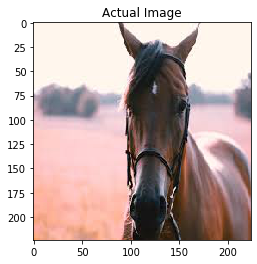

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


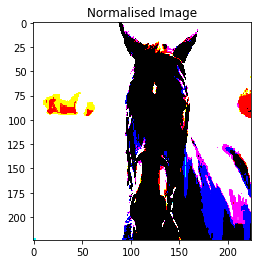

In [63]:
plt.title("Actual Image")
plt.imshow(img)
plt.show()
plt.title("Normalised Image")
plt.imshow(x[0])
plt.show()

In [64]:
preds = model_new.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
num_to_labels = {0:'cat',1:'dog',2:'horse',3:'human'}

In [65]:
def decodermlal(preds):
    max_class = np.argmax(preds,axis=1)
    return [num_to_labels[x] for x in max_class]

In [69]:
print('Predicted:', decodermlal(preds))

Predicted: ['horse']


In [70]:
preds.shape

(1, 4)

In [71]:
print(preds)

[[6.2941737e-04 1.3835172e-03 9.2926246e-01 6.8724632e-02]]
